In [105]:
import importlib
from sklearn.utils import gen_batches
import numpy as np
from numpy.linalg import norm
from Code.SGDPLS import SGDPLS
from Code.OLPLS import OLPLS
from Code.CIPLS import CIPLS
from Code.SIMPLS import SIMPLS
from Code.IPLS import IPLS
from Code.PLS1 import IPLS1
import h5py
# ----------
import seaborn as sns
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle


import matplotlib.pyplot as plt
plt.style.use('ggplot')

from pytictoc import TicToc
tim=TicToc()

In [106]:
with np.load("./data/lfw.npz") as data:
    fea_train = data['fea_train']
    fea_test  = data['fea_test']
    X_train    = data['X_train']
    label_train    = data['y_train']
    X_test    = data['X_test']
    label_test    = data['y_test']
print(fea_train.shape)
print(fea_test.shape)
# print(X_train.shape)
# print(X_test.shape)
print(label_train.shape)
print(label_test.shape)


(2200, 512)
(1000, 512)
(2200,)
(1000,)


In [107]:
# X_train, X_test, y_train, y_test = train_test_split(
#     fea_train, label_train, test_size=0.1, random_state=42)

# def Batch_Update_CV(pls_i):
#     pls = copy.deepcopy(pls_i)
#     X_score_train = np.zeros((X_train.shape[0], 1))
#     # try:
#     for i,batch in enumerate(gen_batches(X_train.shape[0], 100)):
#         pls.fit(X_train[batch], y_train[batch])
#         X_score_train[batch] = norm(pls.transform(X_train[batch]), ord=1, axis=1, keepdims=True)

#     X_score_test  = norm(pls.transform(X_test), ord=1, axis=1, keepdims=True)
#     y_pred = LogisticRegression(penalty=None).fit(X_score_train, y_train) \
#                                              .predict(X_score_test)
#     score = accuracy_score(y_test, y_pred)
#     # except Exception as e:
#     #     print("-"*20)
#     #     print(" Error: ", e)
#     #     score = np.nan
#     return score

# def Model_Score(pls):
#     pls.fit(X_train, y_train)
#     X_score_train = norm(pls.transform(X_train), ord=1, axis=1, keepdims=True)
#     X_score_test  = norm(pls.transform(X_test), ord=1, axis=1, keepdims=True)
#     y_pred = LogisticRegression(penalty=None).fit(X_score_train, y_train) \
#                                              .predict(X_score_test)

# #     return accuracy_score(y_test, y_pred)

In [108]:
fea_train, label_train = shuffle(fea_train, label_train, random_state=42)

n_train = fea_train.shape[0]
batch_size = 100
batch_num = int(n_train/batch_size)
print(f"n_train: {n_train:d}; batch_num: {batch_num:d}, batch_size: {batch_size:d}")

# batches = gen_batches(n_train, batch_size)
train_ind = slice((None, n_train))
trainset = [ slice((i+1)*batch_size) for i in range(batch_num)]

samples = [(i+1)*batch_size for i in range(batch_num)]


n_train: 2200; batch_num: 22, batch_size: 100


In [118]:
def RunExp(method, PLS, is_inc, save):
    tim = TicToc()
    timlist=np.zeros((2, len(trainset)))
    timlist[0] = np.array(samples)
    X_score_train = np.zeros((fea_train.shape[0], 1))
    if (is_inc):
        for i,s in enumerate(gen_batches(n_train, batch_size)):
            tim.tic()
            PLS.fit(fea_train[s], label_train[s])
            timlist[1,i] = tim.tocvalue()
            X_score_train[s] = norm(PLS.transform(fea_train[s]), ord=1, axis=1, keepdims=True)
    else:
        for i,s in enumerate(trainset):
            tim.tic()
            PLS.fit(fea_train[s], label_train[s])
            timlist[1,i] = tim.tocvalue()
        X_score_train = norm(PLS.transform(fea_train), ord=1, axis=1, keepdims=True)

    X_score_test  = norm(PLS.transform(fea_test), ord=1, axis=1, keepdims=True)
    y_pred = LogisticRegression(penalty=None).fit(X_score_train, label_train) \
                                              .predict(X_score_test)
    acc = accuracy_score(label_test, y_pred)

    if (save==1):
        with h5py.File(f"./Results/PLS1_LFW_{method}.h5", "w") as f:
            f_acc = f.create_dataset('acc', data=acc)
            f_tim = f.create_dataset('timer', data=timlist, maxshape=timlist.shape)


In [127]:
def Read_Results(method):
    with h5py.File(f"./Results/PLS1_LFW_{method}.h5", "r") as f:
        dat={'timer': f['timer'][:],
             'acc':  f['acc']}
    return dat

def timer_stats(method, timer):
    print(f"{method:s} timer\n"
      + f"  Ave: {np.mean(timer):.4f}\n"
      + f"  Std: {np.std(timer):.4f}")

In [120]:
from sklearn.cross_decomposition import PLSRegression

save=1
tim.tic()

RunExp('NIPALS', PLSRegression(n_components=31, scale=False),
       False, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 2.504143798723817


In [114]:
save=1
tim.tic()

RunExp('SIMPLS', SIMPLS(n_components=34),
       False, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 0.47132330387830734


In [121]:
from Code.ISIMPLS import ISIMPLS
save=1
tim.tic()
RunExp('ISIMPLS', ISIMPLS(n_components=41), 
       True, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 0.28013449162244797


In [122]:
from Code.PLS1 import PLS1
save=1
tim.tic()
RunExp('PLS1', PLS1(n_components=69),
       False, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 0.6979412492364645


In [123]:
from Code.PLS1 import IPLS1
save=1
tim.tic()
RunExp('IPLS1', IPLS1(n_components=89),
       True, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 0.42055963538587093


In [ ]:
from Code.OLPLS import OLPLS
save=1
tim.tic()
RunExp('OLPLS', OLPLS(n_components=)
       True, save)
print("elapsed time:", tim.tocvalue() )

In [ ]:
from Code.SGDPLS import SGDPLS
save=1
tim.tic()
RunExp('SGDPLS', SGDPLS(n_components=99, eta=9.209225155490904e-07), 
       True, save)
print("elapsed time:", tim.tocvalue() )

In [124]:
from Code.CIPLS import CIPLS
save=1
tim.tic()
RunExp('CIPLS', CIPLS(n_components=5), 
       True, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 4.544442962855101


In [125]:
from Code.IPLS import IPLS
save=1
tim.tic()
RunExp('IPLS', IPLS(n_components=8), 
       True, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 3.589343210682273


In [129]:
NIPALS  = Read_Results('NIPALS')
# OLPLS   = Read_Results('OLPLS')
PLS1    = Read_Results('PLS1')
IPLS1   = Read_Results('IPLS1')
SIMPLS  = Read_Results('SIMPLS')
ISIMPLS = Read_Results('ISIMPLS')
CIPLS   = Read_Results('CIPLS')
IPLS    = Read_Results('IPLS')

timer_stats("NIPALS", NIPALS['timer'][1])
timer_stats("SIMPLS", SIMPLS['timer'][1])
timer_stats("PLS1", PLS1['timer'][1])

# timer_stats("OLPLS", OLPLS['timer'][1])
timer_stats("ISIMPLS", ISIMPLS['timer'][1])
timer_stats("IPLS1", IPLS1['timer'][1])
timer_stats("CIPLS", CIPLS['timer'][1])
timer_stats("IPLS", IPLS['timer'][1])


NIPALS timer
  Ave: 0.1118
  Std: 0.0530
SIMPLS timer
  Ave: 0.0195
  Std: 0.0092
PLS1 timer
  Ave: 0.0302
  Std: 0.0141
ISIMPLS timer
  Ave: 0.0112
  Std: 0.0020
IPLS1 timer
  Ave: 0.0172
  Std: 0.0015
CIPLS timer
  Ave: 0.2036
  Std: 0.0053
IPLS timer
  Ave: 0.1411
  Std: 0.0090


<Figure size 640x480 with 0 Axes>

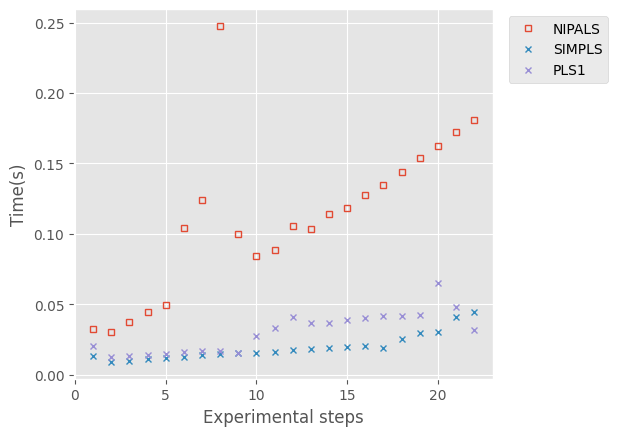

In [130]:
N_steps= len(ISIMPLS['timer'][0])
plt.subplots_adjust(right=.65)
fig, ax = plt.subplots()
ms = 4

plt.subplots_adjust(right=.78)

plt.plot(range(1,N_steps+1), NIPALS['timer'][1],
                label='NIPALS', ls='', marker='s', markersize=ms, fillstyle='none')
plt.plot(range(1,N_steps+1), SIMPLS['timer'][1],
                label='SIMPLS', ls='', marker='x', markersize=ms, fillstyle='none')
plt.plot(range(1,N_steps+1), PLS1['timer'][1],
                label='PLS1', ls='', marker='v', markersize=ms, fillstyle='none')


ax.set_xlabel("Experimental steps")
ax.set_ylabel("Time(s)")
ax.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.savefig('./fig/LFW_full.pdf')
# plt.close()

<Figure size 640x480 with 0 Axes>

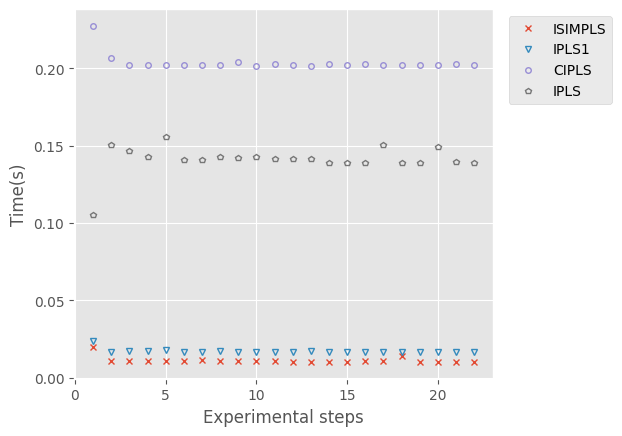

In [132]:
N_steps= len(ISIMPLS['timer'][0])
plt.subplots_adjust(right=.65)
fig, ax = plt.subplots()
ms = 4

plt.subplots_adjust(right=.78)

plt.plot(range(1,N_steps+1), ISIMPLS['timer'][1],
                label='ISIMPLS', ls='', marker='x', markersize=ms, fillstyle='none')
plt.plot(range(1,N_steps+1), IPLS1['timer'][1],
                label='IPLS1', ls='', marker='v', markersize=ms, fillstyle='none')
plt.plot(range(1,N_steps+1), CIPLS['timer'][1],
                label='CIPLS', ls='', marker='o', markersize=ms, fillstyle='none')
plt.plot(range(1,N_steps+1), IPLS['timer'][1],
                label='IPLS', ls='', marker='p', markersize=ms, fillstyle='none')



ax.set_xlabel("Experimental steps")
ax.set_ylabel("Time(s)")
ax.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.savefig('./fig/LFW_inc.pdf')
# plt.close()